In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
from mlxtend.frequent_patterns import apriori, association_rules


# Set Plotly theme
pio.templates.default = "plotly_dark"

## Loading the transactions


In [2]:
df_transactions = pd.read_csv("./data/transactions.csv")

In [3]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4539 entries, 0 to 4538
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   POS Txn  4539 non-null   uint64
 1   Dept     4539 non-null   object
 2   ID       4539 non-null   int64 
 3   Sales U  4539 non-null   int64 
dtypes: int64(2), object(1), uint64(1)
memory usage: 142.0+ KB


In [4]:
df_transactions.head()

,POS Txn,Dept,ID,Sales U
0,16120100160021008773,0261:HOSIERY,250,2
1,16120100160021008773,0634:VITAMINS & HLTH AIDS,102,1
2,16120100160021008773,0879:PET SUPPLIES,158,2
3,16120100160021008773,0973:CANDY,175,2
4,16120100160021008773,0982:SPIRITS,176,1


## Exploratory Data Analysis


In [5]:
# Rename columns
df_transactions.columns = ["transaction_id", "department", "department_id", "units"]
df_transactions.head()

,transaction_id,department,department_id,units
0,16120100160021008773,0261:HOSIERY,250,2
1,16120100160021008773,0634:VITAMINS & HLTH AIDS,102,1
2,16120100160021008773,0879:PET SUPPLIES,158,2
3,16120100160021008773,0973:CANDY,175,2
4,16120100160021008773,0982:SPIRITS,176,1


In [6]:
num_of_departments = df_transactions["department"].nunique()
print(f"Number of departments: {num_of_departments}")

Number of departments: 160


In [7]:
num_of_departments = df_transactions["department_id"].nunique()
print(f"Number of department IDs: {num_of_departments}")

Number of department IDs: 160


In [8]:
num_of_tx = df_transactions["transaction_id"].nunique()
print(f"Number of transactions: {num_of_tx}")

Number of transactions: 2064


In [9]:
# Can a department (product) appear multiple times in the same transaction?
df_transactions.groupby(["transaction_id", "department"]).size().reset_index(
    name="count"
).head(10)

,transaction_id,department,count
0,16120100160021008773,0261:HOSIERY,1
1,16120100160021008773,0634:VITAMINS & HLTH AIDS,1
2,16120100160021008773,0879:PET SUPPLIES,1
3,16120100160021008773,0973:CANDY,1
4,16120100160021008773,0982:SPIRITS,1
5,16120100160021008773,0983:WINE,1
6,16120100160021008773,0991:TOBACCO,1
7,16120100160021008774,0597:HEALTH AIDS,1
8,16120100160021008774,0604:PERSONAL CARE,1
9,16120100160021008775,0819:PRE-RECORDED A/V,1


In [10]:
# Check for negative units
df_transactions[df_transactions["units"] < 0].head(10)

,transaction_id,department,department_id,units
1301,16120100160024002255,0984:BEER,178,-1
2490,16120100160035008740,0845:AS SEEN ON TV,146,-1
2533,16120100160035008757,0380:MENS ACTIVEWEAR,46,-1
3731,16120100160077007433,0411:PEGABLES,50,-1
3732,16120100160077007434,0291:WOMENS FTWR:DRS/CAS,28,-1
3733,16120100160077007436,0834:COOKWARE,295,-1
3734,16120100160077007439,0411:PEGABLES,50,-2
3735,16120100160077007439,0593:PRESTIGE COSMETICS,270,-1
3736,16120100160077007439,0603:BEAUTY CARE,99,-1
3737,16120100160077007441,0291:WOMENS FTWR:DRS/CAS,28,-1


In [11]:
# Drop rows with negative units
df_transactions = df_transactions[df_transactions["units"] > 0]

In [12]:
# Count departments with biggest number of transactions
tx_count_by_department = df_transactions["department"].value_counts().head(10)

tx_count_fig = px.bar(
    tx_count_by_department,
    color=tx_count_by_department.index,
    title="Top 10 departments with the most transactions",
    labels={"value": "Number of transactions"},
    orientation="h",
)
tx_count_fig.update_layout(showlegend=False)
tx_count_fig.show()

In [13]:
# Count sold units per department
units_sold_by_department = (
    df_transactions.groupby("department")["units"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

sold_units_fig = px.bar(
    units_sold_by_department,
    color=units_sold_by_department.index,
    title="Top 10 departments with the most units sold",
    labels={"value": "Units sold"},
    orientation="h",
)
sold_units_fig.update_layout(showlegend=False)
sold_units_fig.show()

In [14]:
# Unify count charts
fig = make_subplots(
    rows=1, cols=2, subplot_titles=("Number of transactions", "Units sold")
)

for trace in tx_count_fig.data:
    fig.add_trace(trace, row=1, col=1)

for trace in sold_units_fig.data:
    fig.add_trace(trace, row=1, col=2)

fig.update_layout(
    showlegend=False,
    title_text="Top 10 departments with the most transactions and units sold",
)

fig.show()

In [15]:
# Which departments have the highest variance in the number of units sold?
units_sold_variance = (
    df_transactions.groupby("department")["units"]
    .std()
    .sort_values(ascending=False)
    .head(25)
)

units_sold_variance_fig = px.bar(
    units_sold_variance,
    color=units_sold_variance.index,
    title="Top 25 departments with the highest variance in units sold",
    labels={"value": "Variance"},
    orientation="h",
)
units_sold_variance_fig.update_layout(showlegend=False)
units_sold_variance_fig.show()

In [16]:
# What is the distribution of units sold per department in the different transactions?
px.box(
    df_transactions,
    x="department",
    y="units",
    title="Distribution of units sold per department",
    labels={"units": "Units sold"},
)

In [17]:
# Which departments have the highest mean in the number of units sold?
units_sold_mean = (
    df_transactions.groupby("department")["units"]
    .mean()
    .sort_values(ascending=False)
    .head(25)
)

units_sold_mean_fig = px.bar(
    units_sold_mean,
    color=units_sold_mean.index,
    title="Top 25 departments with the highest mean in units sold",
    labels={"value": "mean"},
    orientation="h",
)
units_sold_mean_fig.update_layout(showlegend=False)
units_sold_mean_fig.show()

## Create pivot table for the transactions


In [18]:
# Create a pivot table with the transactions and departments
df_transactions_pivot = df_transactions.pivot_table(
    index="transaction_id", columns="department", values="units", aggfunc="sum"
)

# Convert the pivot table to a binary matrix
df_transactions_pivot = df_transactions_pivot.map(lambda x: True if x > 0 else False)

df_transactions_pivot.head()

department,0002:BARBER RETAIL,0009:FLORAL SERV/SUPPLIES,0012:LOCAL GIFTS/FOODS,0014:REPAIRS,0016:FINANCIAL SERVICES,0018:OTHER DIRECT SERVICE,0033:VENDING RETAIL,0056:SOUVENIR,0066:VENDING/AMUSEMENT MA,0071:BEAUTY RETAIL,...,0941:BEDDING,0961:GENERAL GROCERIES,0962:BEVERAGES,0965:PERISHABLES,0973:CANDY,0982:SPIRITS,0983:WINE,0984:BEER,0991:TOBACCO,0999:UNSCANNED ITEMS
transaction_id,,,,,,,,,,,,,,,,,,,,,
16120100160021008773,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,True,False,True,False
16120100160021008774,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16120100160021008775,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
16120100160021008776,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
16120100160021008777,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [19]:
# Remove the name of the columns
df_transactions_pivot = (
    df_transactions_pivot.rename_axis(None, axis=1)
    .reset_index()
    .drop(columns="transaction_id")
)
df_transactions_pivot.head()

,0002:BARBER RETAIL,0009:FLORAL SERV/SUPPLIES,0012:LOCAL GIFTS/FOODS,0014:REPAIRS,0016:FINANCIAL SERVICES,0018:OTHER DIRECT SERVICE,0033:VENDING RETAIL,0056:SOUVENIR,0066:VENDING/AMUSEMENT MA,0071:BEAUTY RETAIL,...,0941:BEDDING,0961:GENERAL GROCERIES,0962:BEVERAGES,0965:PERISHABLES,0973:CANDY,0982:SPIRITS,0983:WINE,0984:BEER,0991:TOBACCO,0999:UNSCANNED ITEMS
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,True,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [20]:
df_transactions_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1943 entries, 0 to 1942
Columns: 156 entries, 0002:BARBER RETAIL to 0999:UNSCANNED ITEMS
dtypes: bool(156)
memory usage: 296.1 KB


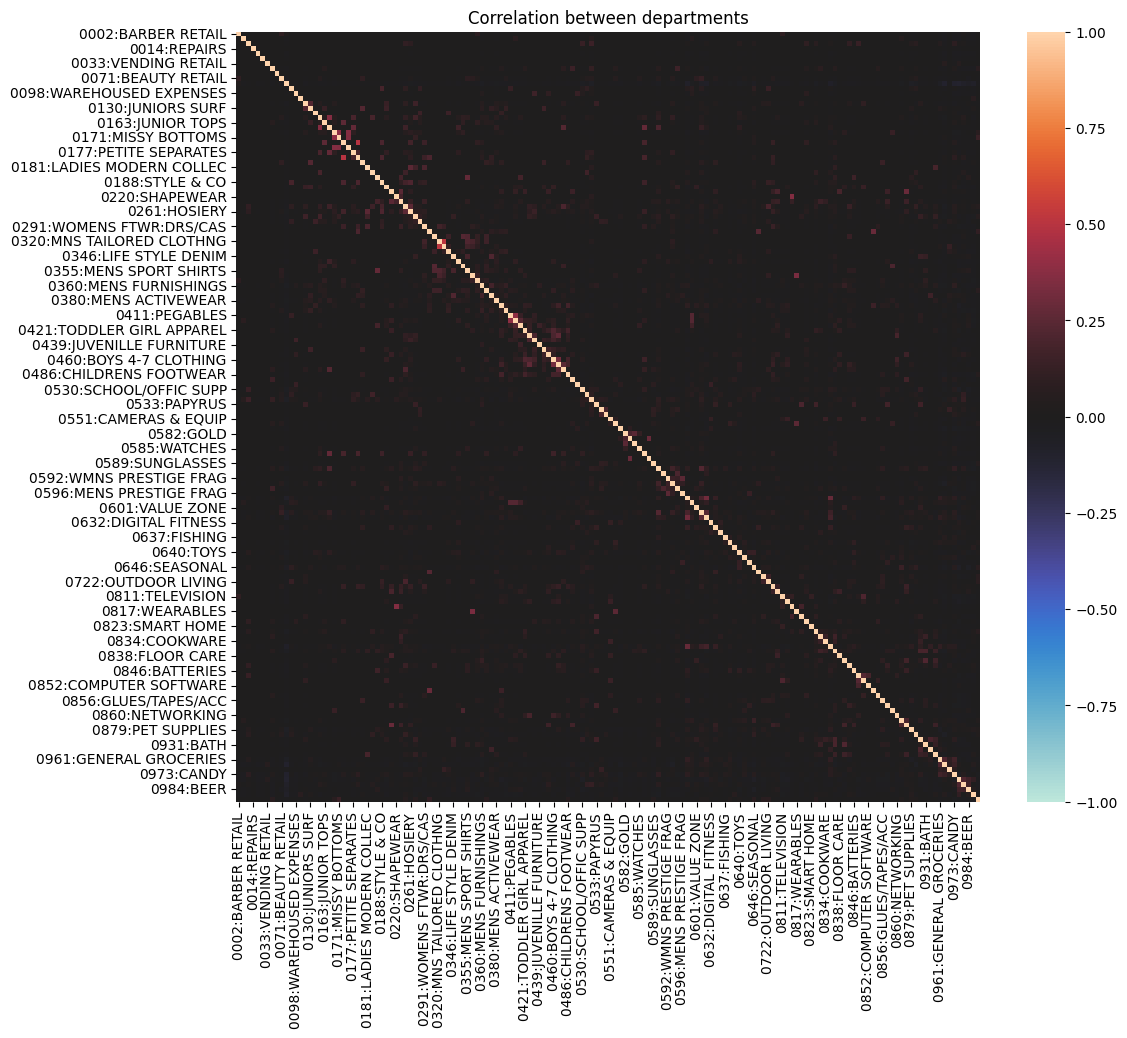

In [21]:
# Show the correlation between the departments
plt.figure(figsize=(12, 10))
sns.heatmap(df_transactions_pivot.corr(), center=0, vmin=-1, vmax=1, annot=False)
plt.title("Correlation between departments")
plt.show()

## Market Basket Analysis with Apriori Algorithm


In [22]:
# Generate a list of frequent itemsets, with a support between 2% and 5%. Based on previous tests,
# this support results in 40 to 100 transactions, which is a reasonable number for the association
# rules. A bigger support would result in a smaller number of transactions, which would make the
# association rules less interesting.
frequent_itemsets = apriori(
    df_transactions_pivot, min_support=0.02, use_colnames=True, verbose=1
)

Processing 165 combinations | Sampling itemset size 3


In [23]:
# How many frequent itemsets were generated?
print(f"Number of frequent itemsets: {len(frequent_itemsets)}")

Number of frequent itemsets: 36


In [24]:
# Add a "size" column for the number of items in the itemset
frequent_itemsets["size"] = frequent_itemsets["itemsets"].apply(len)

In [25]:
frequent_itemsets

,support,itemsets,size
0,0.057643,(0072:BARBER SERVICES),1
1,0.024704,(0360:MENS FURNISHINGS),1
2,0.024189,(0380:MENS ACTIVEWEAR),1
3,0.027277,(0530:SCHOOL/OFFIC SUPP),1
4,0.053011,(0532:AMERICAN GREETINGS),1
5,0.026248,(0590:MASS COSMETICS),1
6,0.022645,(0593:PRESTIGE COSMETICS),1
7,0.102934,(0597:HEALTH AIDS),1
8,0.067936,(0603:BEAUTY CARE),1
9,0.077200,(0604:PERSONAL CARE),1


In [26]:
# Example: calculate the support for the itemset {0982:SPIRITS}
spirts_support = df_transactions_pivot["0982:SPIRITS"].sum() / len(
    df_transactions_pivot
)
print(f"Support for 0982:SPIRITS: {spirts_support:.6f}")

Support for 0982:SPIRITS: 0.161606


In [27]:
# Filter itemsets with at least 2 items
frequent_itemsets[frequent_itemsets["size"] >= 2]

,support,itemsets,size
24,0.021616,"(0603:BEAUTY CARE, 0597:HEALTH AIDS)",2
25,0.032939,"(0604:PERSONAL CARE, 0597:HEALTH AIDS)",2
26,0.031395,"(0836:HOUSEHOLD CLEANING, 0597:HEALTH AIDS)",2
27,0.023160,"(0973:CANDY, 0597:HEALTH AIDS)",2
28,0.021101,"(0603:BEAUTY CARE, 0604:PERSONAL CARE)",2
29,0.022131,"(0961:GENERAL GROCERIES, 0962:BEVERAGES)",2
30,0.020072,"(0961:GENERAL GROCERIES, 0973:CANDY)",2
31,0.034483,"(0962:BEVERAGES, 0973:CANDY)",2
32,0.025219,"(0962:BEVERAGES, 0982:SPIRITS)",2
33,0.039629,"(0983:WINE, 0982:SPIRITS)",2


In [31]:
# Create association rules based on the frequent itemsets
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(0603:BEAUTY CARE),(0597:HEALTH AIDS),0.067936,0.102934,0.021616,0.318182,3.091136,0.014623,1.315697,0.725803
1,(0604:PERSONAL CARE),(0597:HEALTH AIDS),0.077200,0.102934,0.032939,0.426667,4.145067,0.024992,1.564651,0.822225
2,(0597:HEALTH AIDS),(0604:PERSONAL CARE),0.102934,0.077200,0.032939,0.320000,4.145067,0.024992,1.357059,0.845812
3,(0836:HOUSEHOLD CLEANING),(0597:HEALTH AIDS),0.081318,0.102934,0.031395,0.386076,3.750728,0.023024,1.461201,0.798301
4,(0597:HEALTH AIDS),(0836:HOUSEHOLD CLEANING),0.102934,0.081318,0.031395,0.305000,3.750728,0.023024,1.321845,0.817537
5,(0603:BEAUTY CARE),(0604:PERSONAL CARE),0.067936,0.077200,0.021101,0.310606,4.023384,0.015857,1.338567,0.806225
6,(0961:GENERAL GROCERIES),(0962:BEVERAGES),0.050952,0.130211,0.022131,0.434343,3.335689,0.015496,1.537663,0.737805
7,(0961:GENERAL GROCERIES),(0973:CANDY),0.050952,0.141534,0.020072,0.393939,2.783361,0.012861,1.416469,0.675121
8,(0983:WINE),(0982:SPIRITS),0.098302,0.161606,0.039629,0.403141,2.494598,0.023743,1.404678,0.664450
9,(0984:BEER),(0982:SPIRITS),0.067936,0.161606,0.025733,0.378788,2.343901,0.014755,1.349610,0.615152
